# Detecting Transportation after the Collision of Spaceship Titanic

In this Jupyter Notebook, I will explore a fascinating cosmic mystery surrounding the Spaceship Titanic, an interstellar passenger liner that collid with a spacetime anomaly while en route to its destination. As a result of this collision, almost half of the passenger were transported to an alternate dimension.

Our objective is to utilize the power of data science and machine learning techniques to detect whether a person has been transported to this alternate dimension or not. By analyze the available data and building a predictive model, we can uncover valuable insights and potentially assists in the search and recovery effort.

 ### The notebook will be structured as follows:

#### 1.Data Collection and Preprocessing
- 1.1. Importing libraries
- 1.2. Reading the data
- 1.3. Analyzing the Files

#### 2.Exploratory Data Analysis

#### 3.Feature Engineering
- 3.1.Group size - PassengerId
- 3.2.HomePlanet
- 3.3.CryoSleep
- 3.4.Cabin
- 3.5.Destination
- 3.6.Age
- 3.7 VIP
- 3.8.RoomService, FoodCourt, ShoppingMall, Spa, VRDeck
- 3.9.Name

#### 4.Encoding the Categorical Features
- 4.1 Manual Encoding
- 4.2 Using TargetEncoding

#### 5.Data Splitting

#### 6.Model Training
- 6.1. Traditional Machine Learning Models
  - 6.1.1 Chosing the best Hyperparameters
  - 6.1.2 Machine Learning Models Training
- 6.2. Deep Learning Model

#### 7. Models Evaluation

#### 8. Conclusion

#### 9. Future Steps


## 1.Data Collection and Preprocessing
##### 1.1. Importing libraries

In [1]:
# Importing libraries

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as metrics
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
%matplotlib inline

##### 1.2. Reading the data

In [2]:
df_train = pd.read_csv('train (2).csv') # train set
df_test = pd.read_csv('test (1).csv')   # test set
df = pd.concat([df_train, df_test], axis = 0) # concat them into one dataframe!

##### 1.3. Analyzing the Files

In [3]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,12700.0,28.771969,14.387261,0.0,19.0,27.0,38.0,79.0
RoomService,12707.0,222.897852,647.596664,0.0,0.0,0.0,49.0,14327.0
FoodCourt,12681.0,451.961675,1584.370747,0.0,0.0,0.0,77.0,29813.0
ShoppingMall,12664.0,174.906033,590.558690,0.0,0.0,0.0,29.0,23492.0
Spa,12686.0,308.476904,1130.279641,0.0,0.0,0.0,57.0,22408.0
VRDeck,12702.0,306.789482,1180.097223,0.0,0.0,0.0,42.0,24133.0


<Axes: >

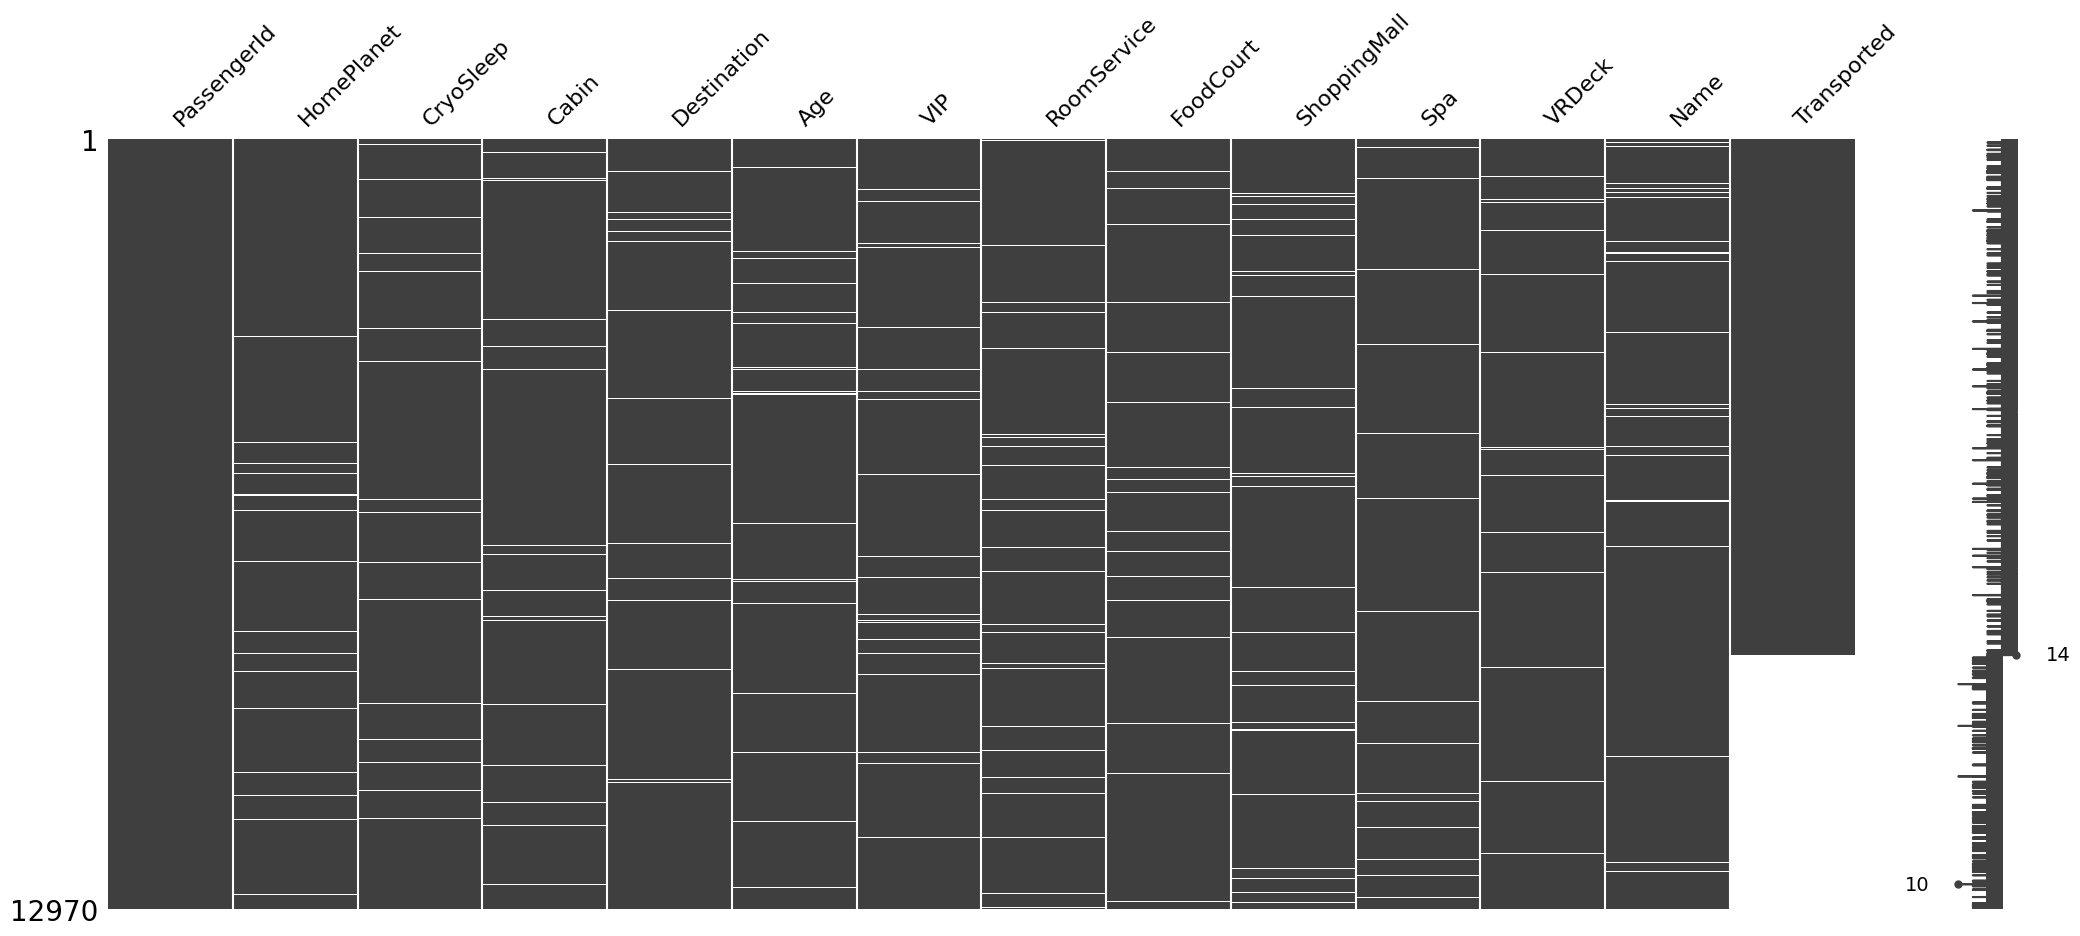

In [4]:
msno.matrix(df) # check the missing values

In [5]:
def check(df): # function to check the dataframe --> dataframe
    l=[]
    columns=df.columns
    for col in columns:
        dtypes=df[col].dtypes
        nunique=df[col].nunique()
        sum_null=df[col].isnull().sum()
        sum_mean = df[col].isnull().mean()
        l.append([col,dtypes,nunique,sum_null,sum_mean])
    df_check=pd.DataFrame(l)
    df_check.columns=['column','dtypes','nunique','sum_null','sum_mean']
    return df_check 

check(df)

,column,dtypes,nunique,sum_null,sum_mean
0,PassengerId,object,12970,0,0.000000
1,HomePlanet,object,3,288,0.022205
2,CryoSleep,object,2,310,0.023901
3,Cabin,object,9825,299,0.023053
4,Destination,object,3,274,0.021126
5,Age,float64,80,270,0.020817
6,VIP,object,2,296,0.022822
7,RoomService,float64,1578,263,0.020278
8,FoodCourt,float64,1953,289,0.022282
9,ShoppingMall,float64,1367,306,0.023593


## 2.Exploratory Data Analysis

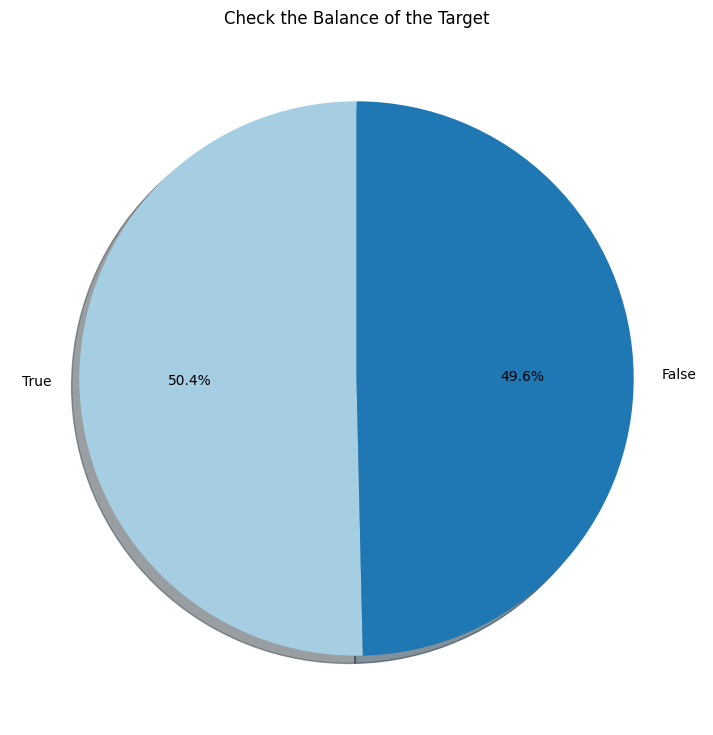

In [6]:
pt = df['Transported'].value_counts() # check if the label is balanced or not
labels=pt.index
sizes=pt.values
plt.figure(figsize=(12,9))
colors = sns.color_palette('Paired')
plt.pie(sizes,labels=labels,autopct='%1.1f%%',
        shadow=True,colors=colors,startangle=90)
plt.title('Check the Balance of the Target')
plt.show()

###### The transported showcases a balanced distribution of true and false labels.

Text(0.5, 1.0, 'Age Distribution')

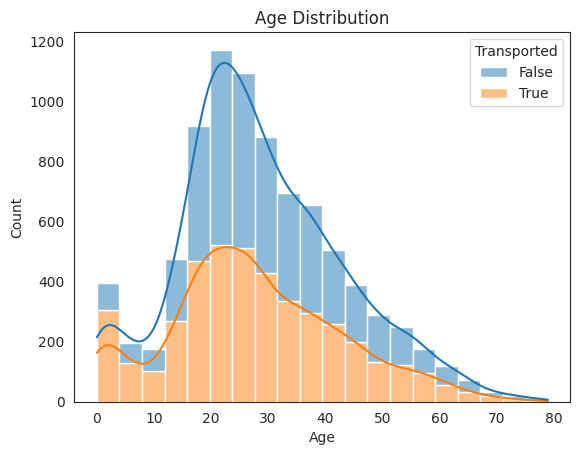

In [7]:
sns.set_style('white') # AGE + Transported plotting
sns.histplot(x='Age', hue='Transported', data=df_train, bins=20, multiple="stack", kde=True, color='black')
plt.title('Age Distribution')

Text(0.5, 1.0, 'HomePlanet Distribution with the Distination')

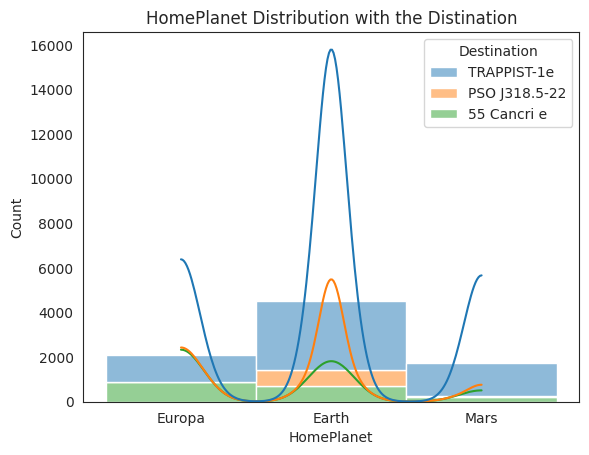

In [8]:
sns.histplot(x = 'HomePlanet', data = df_train, hue = 'Destination', kde = True, multiple='stack')
plt.title('HomePlanet Distribution with the Distination')

Text(0.5, 1.0, 'Home Planet vs Age')

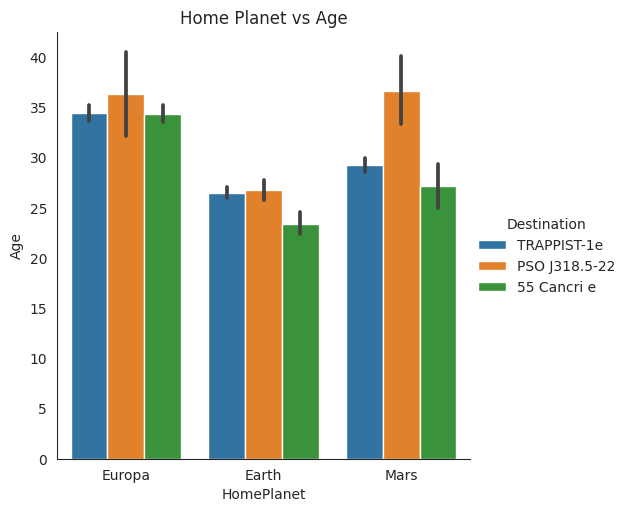

In [9]:
sns.catplot(y="Age", x="HomePlanet", hue="Destination", kind="bar", data=df_train)
plt.title('Home Planet vs Age')

## 3.Feature Engineering

In [10]:
df.shape

(12970, 14)

In [11]:
df.duplicated().sum()

0

##### 3.1.Group size - PassengerId

Each passenger is assigned a distinct identification (ID) represented as gggg_pp, where gggg represents the group they are traveling with, and pp denote their individual number within the groups. While groups typically consist of family members, there are instance where this may not be the case.

By utilizing the 'PassengerID' column, I'm generating a novel attribute called 'Group Size'. This attribute will indicate the number of individual accompanying each passenger.

In [12]:
df['Group_Size'] = df['PassengerId'].apply(lambda x: x.split('_')[1]) # creating new column called "Group_Size"
df.drop('PassengerId', axis = 1, inplace = True) # unique value for all the rows >> unnecessary info

##### 3.2.HomePlanet

Passengers typically depart from their permanent residence planet.

In this dataset, 288 values for 'HomePlanet' are missing. Instead of using a new token like 'Unknown', which could skew predictions due to its smalls representation, we will filling these values while preserving the existing 'HomePlanet' distribution.

In [13]:
tmp = df['HomePlanet'].value_counts() # Knowing the Probability distribution for each planet
planets = tmp.index # ['Earth', 'Europa', 'Mars']
prob = tmp.values 
prob = prob/sum(prob)
planets_prop = dict(zip(planets,prob))
print(f'The Probability distribution for each planet = {planets_prop}')

The Probability distribution for each planet = {'Earth': 0.5413184040372181, 'Europa': 0.24704305314619146, 'Mars': 0.21163854281659045}


In [14]:
# filling the missing values
df.loc[df['HomePlanet'].isnull(), 'HomePlanet'] = np.random.choice(planets, df['HomePlanet'].isnull().sum(), p = prob)

In [15]:
df['HomePlanet'].value_counts()

Earth     7017
Europa    3206
Mars      2747
Name: HomePlanet, dtype: int64

##### 3.3.CryoSleep

This feature denotes whether passengers chose to enter suspended animation during the journey, where they remain confined to their cabins.

'CryoSleep' column has 310 missing values. To fix this, I will assign all the missing values to 'False'. This is correct based on the idea that if a passenger's CryoSleep status isn't recorded, they likely didn't undergo cryosleep.

In [18]:
df['CryoSleep'].mode()[0]

False

In [19]:
df['CryoSleep'].fillna(df['CryoSleep'].mode()[0], inplace=True) # -->> False 

##### 3.4.Cabin

'Cabin' column has 299 missing values. to fill them, I will use Simple Imputer with most_frequent strategy

In [20]:
imputer = SimpleImputer(strategy='most_frequent')  
def simpleImputer(df, column): # creating a function for future usage --> filled column
    categorical_col = df[column]
    categorical_col = np.array(categorical_col).reshape(-1, 1)
    imputer = SimpleImputer(strategy='most_frequent')
    df[column] = imputer.fit_transform(categorical_col)
    return df[column]

In [21]:
df['Cabin'] = simpleImputer(df, 'Cabin') # filling the missing value

In [22]:
df[['Cabin']].head()

,Cabin
0,B/0/P
1,F/0/S
2,A/0/S
3,A/0/S
4,F/1/S


hmmm, the cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard. So..

I will split the 'Cabin' column into three new columns: 'Cabin_deck', 'Cabin_number', and 'Cabin_side'

In [23]:
df[['Cabin_deck', 'Cabin_number', 'Cabin_side']] = df['Cabin'].str.split('/', expand=True) # creating three columns:D
df.drop(['Cabin_number', 'Cabin'], axis = 1, inplace = True)  # unique value for all the rows >> unnecessary info

In [24]:
check(df)

,column,dtypes,nunique,sum_null,sum_mean
0,HomePlanet,object,2,0,0.000000
1,CryoSleep,bool,2,0,0.000000
2,Destination,object,3,274,0.021126
3,Age,float64,80,270,0.020817
4,VIP,object,2,296,0.022822
5,RoomService,float64,1578,263,0.020278
6,FoodCourt,float64,1953,289,0.022282
7,ShoppingMall,float64,1367,306,0.023593
8,Spa,float64,1679,284,0.021897
9,VRDeck,float64,1642,268,0.020663


##### 3.5.Destination

The planet the passenger will be debarking to.

There're 274 missing values for 'Destination'. To handle this, I randomly assign one of the three planets as the destination. This preserves the original distribution and avoids bias towards a specific destination.

In [25]:
df['Destination'].value_counts()/len(df) # probality of each destination

TRAPPIST-1e      0.683963
55 Cancri e      0.203624
PSO J318.5-22    0.091288
Name: Destination, dtype: float64

In [26]:
list(df['Destination'].unique())[:3] 

['TRAPPIST-1e', 'PSO J318.5-22', '55 Cancri e']

In [27]:
# filling the missing values randomly based on the probability for each distination.
df.loc[df['Destination'].isnull(), 'Destination'] = np.random.choice = np.random.choice(['TRAPPIST-1e', 'PSO J318.5-22', '55 Cancri e'], df['Destination'].isnull().sum(), p = [ 0.5 , 0.3 , 0.2])

In [28]:
check(df)

,column,dtypes,nunique,sum_null,sum_mean
0,HomePlanet,object,2,0,0.000000
1,CryoSleep,bool,2,0,0.000000
2,Destination,object,3,0,0.000000
3,Age,float64,80,270,0.020817
4,VIP,object,2,296,0.022822
5,RoomService,float64,1578,263,0.020278
6,FoodCourt,float64,1953,289,0.022282
7,ShoppingMall,float64,1367,306,0.023593
8,Spa,float64,1679,284,0.021897
9,VRDeck,float64,1642,268,0.020663


##### 3.6.Age

The age of the passenger.

For the 'Age' column, I have 270 missing values. To handle this, I will fill them uniformly within one standard deviation of the mean age. This maintains the overall distribution and avoids bias towards a specific age range.

In [29]:
mean_age = df['Age'].mean()
std_age = df["Age"].std()
age_randoms = np.random.uniform(mean_age - std_age, mean_age + std_age, size =  df["Age"].isnull().sum())
df.loc[df['Age'].isnull(), 'Age'] = age_randoms
print(f'mean {mean_age}, std = {std_age}')

mean 28.771968503937007, std = 14.387260917143353


##### 3.7 VIP

Whether the passenger has paid for special VIP service during the voyage.

there are 296 missing values for 'VIP' col. To fix this, I will fill them with 'False'. This assumption is made based on the likelihood that passengers without recorded VIP statu were not VIPs.

In [30]:
df['VIP'].value_counts()/ len(df)

False    0.956130
True     0.021049
Name: VIP, dtype: float64

In [31]:
df['VIP'].fillna(False, inplace=True) # -->> fill them with False

In [32]:
check(df)

,column,dtypes,nunique,sum_null,sum_mean
0,HomePlanet,object,2,0,0.000000
1,CryoSleep,bool,2,0,0.000000
2,Destination,object,3,0,0.000000
3,Age,float64,350,0,0.000000
4,VIP,bool,2,0,0.000000
5,RoomService,float64,1578,263,0.020278
6,FoodCourt,float64,1953,289,0.022282
7,ShoppingMall,float64,1367,306,0.023593
8,Spa,float64,1679,284,0.021897
9,VRDeck,float64,1642,268,0.020663


##### 3.8.RoomService, FoodCourt, ShoppingMall, Spa, VRDeck

The amenities on the Spaceship Titanic include RoomService, FoodCourt, ShoppingMall, Spa, and VRDeck, which represent the amounts a passenger has spent on each luxury facility.

To know the passenger's overall expenditure, I will create a new feature called 'total_spending,' which combines the spending from all these amenities.

But first, I will apply the IterativeImputer technique to fill the missing values in those features. This method utilizes an iterative approach to estimate the missing values based on the relationships between other variables in the dataset.

In [33]:
df_mice = df.copy(deep=True) # creating a temp dataframe
mice_imputer = IterativeImputer()
cols = ['RoomService', 'ShoppingMall', 'Spa', 'VRDeck', 'FoodCourt']
for column in cols:
    df[column] = mice_imputer.fit_transform(df_mice[[column]])

In [34]:
df['Total_spending'] = df['RoomService'] + df['FoodCourt'] + df['ShoppingMall'] + df['Spa'] + df['VRDeck'] # creating new column

In [35]:
check(df)

,column,dtypes,nunique,sum_null,sum_mean
0,HomePlanet,object,2,0,0.000000
1,CryoSleep,bool,2,0,0.000000
2,Destination,object,3,0,0.000000
3,Age,float64,350,0,0.000000
4,VIP,bool,2,0,0.000000
5,RoomService,float64,1579,0,0.000000
6,FoodCourt,float64,1954,0,0.000000
7,ShoppingMall,float64,1368,0,0.000000
8,Spa,float64,1680,0,0.000000
9,VRDeck,float64,1643,0,0.000000


##### 3.9.Name

The first and last names of the passenger.

unique value for all the rows >> unnecessary info, so I am going to drop this column

In [36]:
df[['Name']].head()

,Name
0,Maham Ofracculy
1,Juanna Vines
2,Altark Susent
3,Solam Susent
4,Willy Santantines


In [37]:
df.drop('Name', axis = 1, inplace = True)# unique value for all the rows >> unnecessary info

In [38]:
check(df)

,column,dtypes,nunique,sum_null,sum_mean
0,HomePlanet,object,2,0,0.000000
1,CryoSleep,bool,2,0,0.000000
2,Destination,object,3,0,0.000000
3,Age,float64,350,0,0.000000
4,VIP,bool,2,0,0.000000
5,RoomService,float64,1579,0,0.000000
6,FoodCourt,float64,1954,0,0.000000
7,ShoppingMall,float64,1368,0,0.000000
8,Spa,float64,1680,0,0.000000
9,VRDeck,float64,1643,0,0.000000


## 4.Encoding the Categorical Features

##### 4.1 Manual Encoding

In [39]:
df['HomePlanet'] = df['HomePlanet'].map({'Earth': 0, 'Mars': 1})
df['CryoSleep'] = df['CryoSleep'].astype('int') 
df['Transported'] = df['Transported'].map({True: 0, False: 1})
df['Group_Size'] = df['Group_Size'].astype('int')
df['Cabin_side'] = df['Cabin_side'].map({'P': 0, 'S': 1})
df['VIP'] = df['VIP'].astype(int)

In [40]:
check(df)

,column,dtypes,nunique,sum_null,sum_mean
0,HomePlanet,int64,2,0,0.000000
1,CryoSleep,int64,2,0,0.000000
2,Destination,object,3,0,0.000000
3,Age,float64,350,0,0.000000
4,VIP,int64,2,0,0.000000
5,RoomService,float64,1579,0,0.000000
6,FoodCourt,float64,1954,0,0.000000
7,ShoppingMall,float64,1368,0,0.000000
8,Spa,float64,1680,0,0.000000
9,VRDeck,float64,1643,0,0.000000


##### 4.2 Using TargetEncoding

In [41]:
encoder = TargetEncoder(cols=['Destination', 'Cabin_deck'])
df = encoder.fit_transform(df, df['Transported'])

In [42]:
check(df)

,column,dtypes,nunique,sum_null,sum_mean
0,HomePlanet,int64,2,0,0.000000
1,CryoSleep,int64,2,0,0.000000
2,Destination,float64,3,0,0.000000
3,Age,float64,350,0,0.000000
4,VIP,int64,2,0,0.000000
5,RoomService,float64,1579,0,0.000000
6,FoodCourt,float64,1954,0,0.000000
7,ShoppingMall,float64,1368,0,0.000000
8,Spa,float64,1680,0,0.000000
9,VRDeck,float64,1643,0,0.000000


<Axes: >

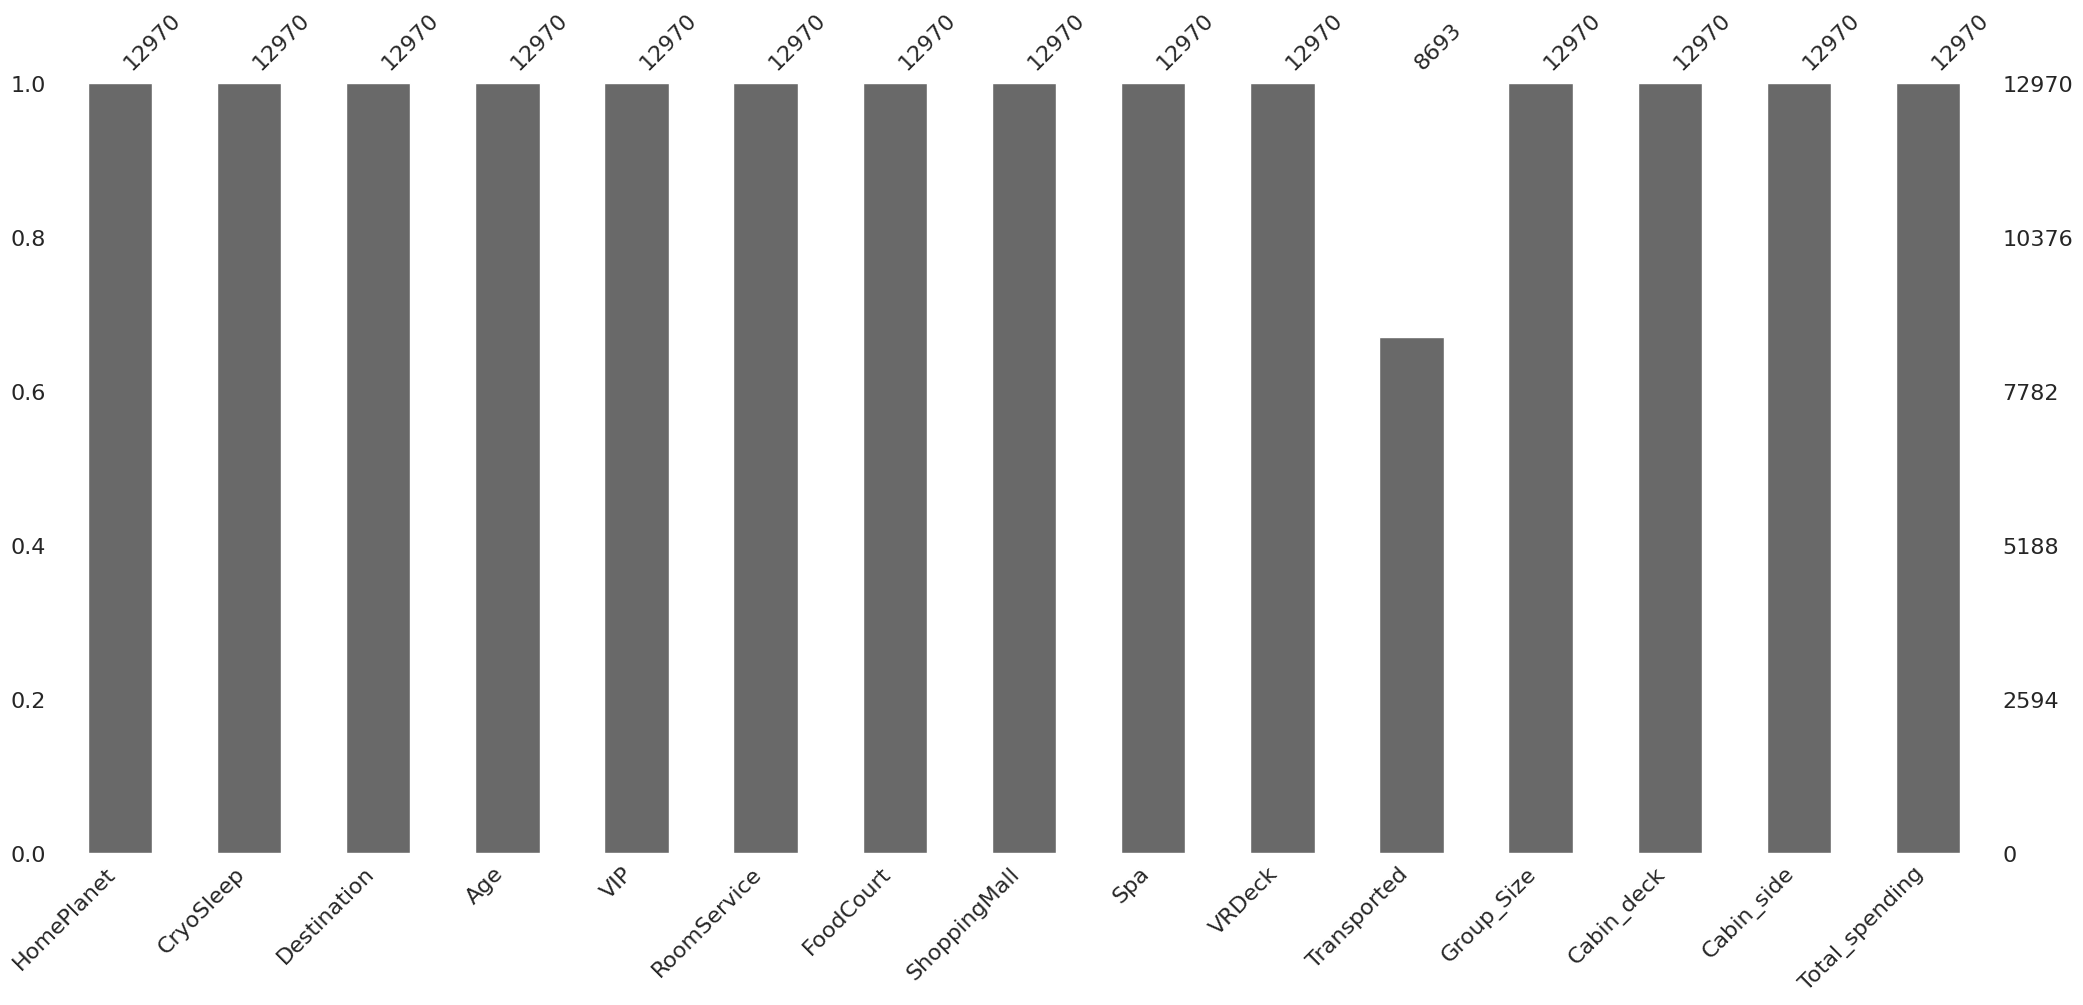

In [43]:
msno.bar(df)

all clean:D

## 5.Data Splitting

Here I am going to split the test set from the training set which I concate them for the preprocessing stage..

In [44]:
df_test  = df[df_train.shape[0]:]
df_train = df[:df_train.shape[0]]
(df_train.shape, df_test.shape)

((8693, 15), (4277, 15))

In [45]:
X = df_train.drop('Transported', axis = 1)
y = df_train[['Transported']]

for the training set, I am going to split the training dataset into Train and Validation set

## 6.Model Training

### 6.1. Traditional Machine Learning Models

Evaluation with KNeighborsClassifier, SVC, DecisionTreeClassifier, XGBClassifier, RandomForestClassifier and LogisticRegression models.

##### 6.1.1 Chosing the best Hyperparameters

To determine the optimal hyperparameters for our dataset, I will employ GridSearchCV. This technique allows us to systematically explore different combinations of hyperparameters and identify the best values for our models. Since the process can be time-consuming, I will run it once and save the results for future reference.

In [46]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


#### The time complexity for the models using GridSearchCV:-
    
- KNeighborsClassifier: The time complexity is O(n_neighbors * weights * algorithm * cv)

- SVC: The time complexity is O(C * kernel * gamma * cv)

- DecisionTreeClassifier: The time complexity is O(criterion * splitter * min_samples_split * min_samples_leaf * max_depth * max_features * cv)

- XGBClassifier: The time complexity is O(n_estimators * max_depth * learning_rate * subsample * colsample_bytree * cv)

- RandomForestClassifier: The time complexity is O(n_estimators * max_depth * min_samples_split * min_samples_leaf * max_features * cv)

- LogisticRegression: The time complexity is O(penalty * C * solver * cv)

In [47]:
'''# KNeighborsClassifier
knn_params = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

# SVC
svc_params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

# DecisionTreeClassifier
dt_params = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'max_features': ['auto', 'sqrt', 'log2', None]
}

# XGBClassifier
xgb_params = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [10, 20, 30, 40],
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

# RandomForestClassifier
rf_params = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [10, 20, 30, 40],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', None]
}

# LogisticRegression
lr_params = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'saga']
}

# GridSearchCV for each model
knn_clf = GridSearchCV(KNeighborsClassifier(), knn_params, cv=2, return_train_score=False)
svc_clf = GridSearchCV(SVC(), svc_params, cv=2, return_train_score=False)
dt_clf = GridSearchCV(DecisionTreeClassifier(), dt_params, cv=2, return_train_score=False)
xgb_clf = GridSearchCV(XGBClassifier(), xgb_params, cv=2, return_train_score=False)
rf_clf = GridSearchCV(RandomForestClassifier(), rf_params, cv=2, return_train_score=False)
lr_clf = GridSearchCV(LogisticRegression(), lr_params, cv=2, return_train_score=False)

# Fit and find the best parameters
# knn_clf.fit(X, y)
svc_clf.fit(X, y)
dt_clf.fit(X, y)
xgb_clf.fit(X, y)
rf_clf.fit(X, y)
lr_clf.fit(X, y)

# Print the best parameters for each model

# print("KNeighborsClassifier best parameters:", knn_clf.best_params_) 
#KNeighborsClassifier best parameters: {'algorithm': 'brute', 'n_neighbors': 7, 'weights': 'uniform'}

    
    
print("SVC best parameters:", svc_clf.best_params_)
print("DecisionTreeClassifier best parameters:", dt_clf.best_params_)
print("XGBClassifier best parameters:", xgb_clf.best_params_)
print("RandomForestClassifier best parameters:", rf_clf.best_params_)
print("LogisticRegression best parameters:", lr_clf.best_params_)
'''
#The results:-
# DecisionTreeClassifier best parameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'splitter': 'best'}

# XGBClassifier best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 50, 'subsample': 0.8}

# RandomForestClassifier best parameters: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}

# LogisticRegression best parameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}

#KNeighborsClassifier best parameters: {'algorithm': 'brute', 'n_neighbors': 7, 'weights': 'uniform'}

# SVC best parameters: {'C': 1, 'kernal': sigmoid, 'gamma': 'scale'}

'# KNeighborsClassifier\nknn_params = {\n    \'n_neighbors\': [3, 5, 7],\n    \'weights\': [\'uniform\', \'distance\'],\n    \'algorithm\': [\'auto\', \'ball_tree\', \'kd_tree\', \'brute\']\n}\n\n# SVC\nsvc_params = {\n    \'C\': [0.1, 1, 10],\n    \'kernel\': [\'linear\', \'poly\', \'rbf\', \'sigmoid\'],\n    \'gamma\': [\'scale\', \'auto\']\n}\n\n# DecisionTreeClassifier\ndt_params = {\n    \'criterion\': [\'gini\', \'entropy\'],\n    \'splitter\': [\'best\', \'random\'],\n    \'min_samples_split\': [2, 5, 10],\n    \'min_samples_leaf\': [1, 2, 4],\n    \'max_depth\': [None, 10, 20, 30, 40, 50],\n    \'max_features\': [\'auto\', \'sqrt\', \'log2\', None]\n}\n\n# XGBClassifier\nxgb_params = {\n    \'n_estimators\': [50, 100, 150, 200],\n    \'max_depth\': [10, 20, 30, 40],\n    \'learning_rate\': [0.1, 0.01, 0.001],\n    \'subsample\': [0.8, 1.0],\n    \'colsample_bytree\': [0.8, 1.0],\n}\n\n# RandomForestClassifier\nrf_params = {\n    \'n_estimators\': [50, 100, 150, 200],\n    \'max

- DecisionTreeClassifier best parameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'splitter': 'best'}

- XGBClassifier best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 50, 'subsample': 0.8}
 
- RandomForestClassifier best parameters: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}

- LogisticRegression best parameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}

- KNeighborsClassifier best parameters: {'algorithm': 'brute', 'n_neighbors': 7, 'weights': 'uniform'}

- SVC best parameters: {'C': 1, 'kernal': sigmoid, 'gamma': 'scale'}

##### 6.1.2 Machine Learning Models Training

I will create a function that iterate 10 times. For each iteration, the function splits the data into training and validation sets. It then trains each classifier on the training set and makes predictions on the validation set. Metrics such as accuracy, precision, and recall are calculated for each classifier to evaluation results for each classifier across multiple iterations based on different shuffiles.

In [48]:
def evaluate_models(X_resampled, y_resampled, num_iterations=10):
    results = []
    for i in range(num_iterations):    
        
        X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)
        
        # Logistic Regression
        lr = LogisticRegression(penalty='l1', C=1, solver='liblinear')
        lr.fit(X_train, y_train)
        lr_predictions = lr.predict(X_valid)
        accuracy_lr = metrics.accuracy_score(y_valid, lr_predictions)
        precision_lr = metrics.precision_score(y_valid, lr_predictions)
        recall_lr = metrics.recall_score(y_valid, lr_predictions)
        f1_lr = metrics.f1_score(y_valid, lr_predictions)
        results.append({'Model': 'Logistic Regression', 'Iteration': i, 'Accuracy': accuracy_lr, 'Precision': precision_lr, 'Recall': recall_lr, 'F1': f1_lr})
        
        # Random Forest
        rc = RandomForestClassifier(max_depth=10, max_features='log2', min_samples_leaf=2, min_samples_split=2, n_estimators=200)
        rc.fit(X_train, y_train)
        predictions_rc = rc.predict(X_valid)
        accuracy_rc = metrics.accuracy_score(y_valid, predictions_rc)
        precision_rc = metrics.precision_score(y_valid, predictions_rc)
        recall_rc = metrics.recall_score(y_valid, predictions_rc)
        f1_rc = metrics.f1_score(y_valid, predictions_rc)
        results.append({'Model': 'Random Forest', 'Iteration': i, 'Accuracy': accuracy_rc, 'Precision': precision_rc, 'Recall': recall_rc, 'F1': f1_rc})
        
        # XGBoost
        XG = XGBClassifier(colsample_bytree=0.8, learning_rate=0.1, max_depth=10, n_estimators=50, subsample=0.8)
        XG.fit(X_train, y_train)
        predictions_XGBoost = XG.predict(X_valid)
        accuracy_XGBoost = metrics.accuracy_score(y_valid, predictions_XGBoost)
        precision_XGBoost = metrics.precision_score(y_valid, predictions_XGBoost)
        recall_XGBoost = metrics.recall_score(y_valid, predictions_XGBoost)
        f1_XGBoost = metrics.f1_score(y_valid, predictions_XGBoost)
        results.append({'Model': 'XGBoost', 'Iteration': i, 'Accuracy': accuracy_XGBoost, 'Precision': precision_XGBoost, 'Recall': recall_XGBoost, 'F1': f1_XGBoost})
        
        # Support Vector Machine
        svm = SVC(C=1, gamma='scale')
        svm.fit(X_train, y_train)
        predictions_svm = svm.predict(X_valid)
        accuracy_svm = metrics.accuracy_score(y_valid, predictions_svm)
        precision_svm = metrics.precision_score(y_valid, predictions_svm)
        recall_svm = metrics.recall_score(y_valid, predictions_svm)
        f1_svm = metrics.f1_score(y_valid, predictions_svm)
        results.append({'Model': 'SVM', 'Iteration': i, 'Accuracy': accuracy_svm, 'Precision': precision_svm, 'Recall': recall_svm, 'F1': f1_svm})

        
        # KNN
        knn = KNeighborsClassifier(algorithm='brute', n_neighbors=7, weights='uniform')
        knn.fit(X_train, y_train)
        predictions_knn = knn.predict(X_valid)
        accuracy_knn = metrics.accuracy_score(y_valid, predictions_knn)
        precision_knn = metrics.precision_score(y_valid, predictions_knn)
        recall_knn = metrics.recall_score(y_valid, predictions_knn)
        f1_knn = metrics.f1_score(y_valid, predictions_knn)
        results.append({'Model': 'KNN', 'Iteration': i, 'Accuracy': accuracy_knn, 'Precision': precision_knn, 'Recall': recall_knn, 'F1': f1_knn})

    
    return pd.DataFrame(results)

df_results = evaluate_models(X, y)
df_results

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
<ipython-input-48-e4dc42821766>:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rc.fit(X_train, y_train)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(

,Model,Iteration,Accuracy,Precision,Recall,F1
0,Logistic Regression,0,0.794135,0.814446,0.757822,0.785114
1,Random Forest,0,0.799310,0.819652,0.763615,0.790642
2,XGBoost,0,0.795860,0.800948,0.783314,0.792033
3,SVM,0,0.779758,0.855030,0.669757,0.751137
4,KNN,0,0.786084,0.805729,0.749710,0.776711
5,Logistic Regression,1,0.785509,0.788902,0.767606,0.778108
6,Random Forest,1,0.793560,0.798788,0.773474,0.785927
7,XGBoost,1,0.791834,0.788235,0.786385,0.787309
8,SVM,1,0.786659,0.830812,0.708920,0.765041
9,KNN,1,0.768833,0.765330,0.761737,0.763529


Now, I'm gonna use Pivot Table and use the mean to give an Organize summary that I can be able to evaluate the models..

In [49]:
df_summary = df_results.pivot_table(index='Model', values=['Accuracy', 'Precision', 'Recall', 'F1'], aggfunc='mean')
a = df_summary 
a

,Accuracy,F1,Precision,Recall
Model,,,,
KNN,0.774928,0.767506,0.780265,0.755539
Logistic Regression,0.792524,0.782923,0.806473,0.760925
Random Forest,0.800863,0.792541,0.812497,0.773786
SVM,0.786141,0.760810,0.845434,0.691836
XGBoost,0.798850,0.794126,0.799613,0.788972


The Random Forest model exhibits a higher level of accuracy compared to alternative models with 80.6% accuracy

To further explore the performance of deep learning models on the dataset, we will now evaluate their effectiveness. While achieving 80% accuracy is commendable, deep learning models have the potential to uncover additional patterns and nuances in the data.

### 6.2. Deep Learning Model

In the context of deep learning, I will now implement a neural network model using the Keras library with a TensorFlow backend.

In [50]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2) # splitting the data for the DL model

In [51]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(51, input_shape=(14,), activation='relu'), 
    tf.keras.layers.Dense(21, activation='relu'),
    tf.keras.layers.Dense(10, activation = 'relu'),
    tf.keras.layers.Dense(5, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

The model architecture takes the form of a sequential model, enabling the stacking of layers sequentially.

- The initial layer, a dense layer, comprises 51 units and receives input data with a shape of (14,). The activation function employed in this layer is rectified linear unit (ReLU).

- Subsequently, a dense layer with 21 units is integrated into the model, applying ReLU activation.

- Another dense layer follows, featuring 10 units and employing ReLU activation.

- The model then incorporates a dense layer consisting of 5 units and employing ReLU activation.

- Finally, a dense layer with 1 unit is integrated, using the sigmoid activation function. This layer serves as the output layer for binary classification tasks.

In [52]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

Optimizer: 'adam' - This popular optimization algorithm is chosen to drive the learning process of the model.

Loss function: 'binary_crossentropy' - As the objective is binary classification.

Metrics: 'accuracy' - The model's performance will be evaluated based on accuracy, a commonly used for classification!!

In [53]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 51)                765       
                                                                 
 dense_1 (Dense)             (None, 21)                1092      
                                                                 
 dense_2 (Dense)             (None, 10)                220       
                                                                 
 dense_3 (Dense)             (None, 5)                 55        
                                                                 
 dense_4 (Dense)             (None, 1)                 6         
                                                                 
Total params: 2,138
Trainable params: 2,138
Non-trainable params: 0
_________________________________________________________________


Here, I will train the model using 50 epoch..

In [54]:
History = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=50)

Epoch 1/50
218/218 [==============================] - 3s 6ms/step - loss: 17.8057 - accuracy: 0.7053 - val_loss: 1.8191 - val_accuracy: 0.7671
Epoch 2/50
218/218 [==============================] - 1s 5ms/step - loss: 1.3088 - accuracy: 0.7440 - val_loss: 1.1938 - val_accuracy: 0.7671
Epoch 3/50
218/218 [==============================] - 1s 5ms/step - loss: 1.0132 - accuracy: 0.7509 - val_loss: 0.8771 - val_accuracy: 0.7010
Epoch 4/50
218/218 [==============================] - 1s 3ms/step - loss: 1.1757 - accuracy: 0.7496 - val_loss: 0.9580 - val_accuracy: 0.7274
Epoch 5/50
218/218 [==============================] - 1s 4ms/step - loss: 1.0624 - accuracy: 0.7426 - val_loss: 1.2655 - val_accuracy: 0.7602
Epoch 6/50
218/218 [==============================] - 1s 4ms/step - loss: 0.8259 - accuracy: 0.7547 - val_loss: 0.6650 - val_accuracy: 0.7826
Epoch 7/50
218/218 [==============================] - 1s 4ms/step - loss: 0.7881 - accuracy: 0.7511 - val_loss: 0.7657 - val_accuracy: 0.7223
Epoch

## 7. Models Evaluation

In [56]:
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, valid_acc = model.evaluate(X_valid, y_valid, verbose=0)

plots for the training and validation loss of the model and the accuracy percent during the training process

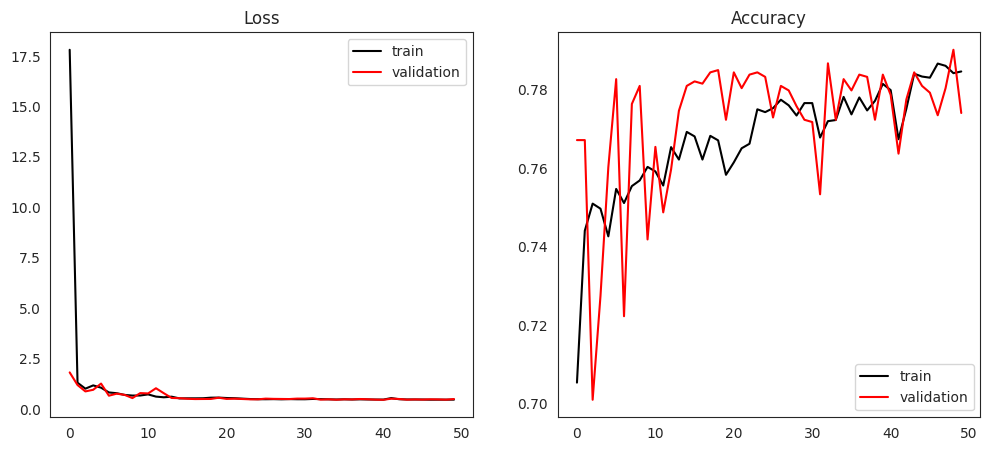

In [57]:
f, (ax1, ax2) = plt.subplots(1,2, figsize = (12,5))
ax1.set_title('Loss') # for the loss plot for each epoch
ax1.plot(History.history['loss'], label='train', color = 'black')
ax1.plot(History.history['val_loss'], label='validation', color = 'red')
ax1.legend()

ax2.set_title('Accuracy') # for accruacy plot for each epoch
ax2.plot(History.history['accuracy'], label='train', color = 'black')
ax2.plot(History.history['val_accuracy'], label='validation', color = 'red')
ax2.legend()

plt.show()

In [58]:
y_pred = model.predict(X_valid)

y_pred_classes = (y_pred > 0.5).astype(int)

precision = precision_score(y_valid, y_pred_classes)
recall = recall_score(y_valid, y_pred_classes)
accuracy = accuracy_score(y_valid, y_pred_classes)
f1 = f1_score(y_valid, y_pred_classes)

55/55 [==============================] - 0s 1ms/step


evaluation metics for the deep learning model..

In [59]:
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)
print("F1:", f1)

Precision: 0.8040201005025126
Recall: 0.7297605473204105
Accuracy: 0.7740080506037953
F1: 0.7650926479378363


In [60]:
results = [
    ["ANN", accuracy, precision, recall, f1]
]
heads = ["Model", "Accuracy", "Precision", "Recall", "F1"]
results = pd.DataFrame(results, columns=heads)
df_results = pd.concat([df_results, results], ignore_index=True)
df_summary = df_results.pivot_table(index='Model', aggfunc='mean', values=['Accuracy', 'Precision', 'Recall', 'F1'])
df_summary

,Accuracy,F1,Precision,Recall
Model,,,,
ANN,0.774008,0.765093,0.804020,0.729761
KNN,0.774928,0.767506,0.780265,0.755539
Logistic Regression,0.792524,0.782923,0.806473,0.760925
Random Forest,0.800863,0.792541,0.812497,0.773786
SVM,0.786141,0.760810,0.845434,0.691836
XGBoost,0.798850,0.794126,0.799613,0.788972


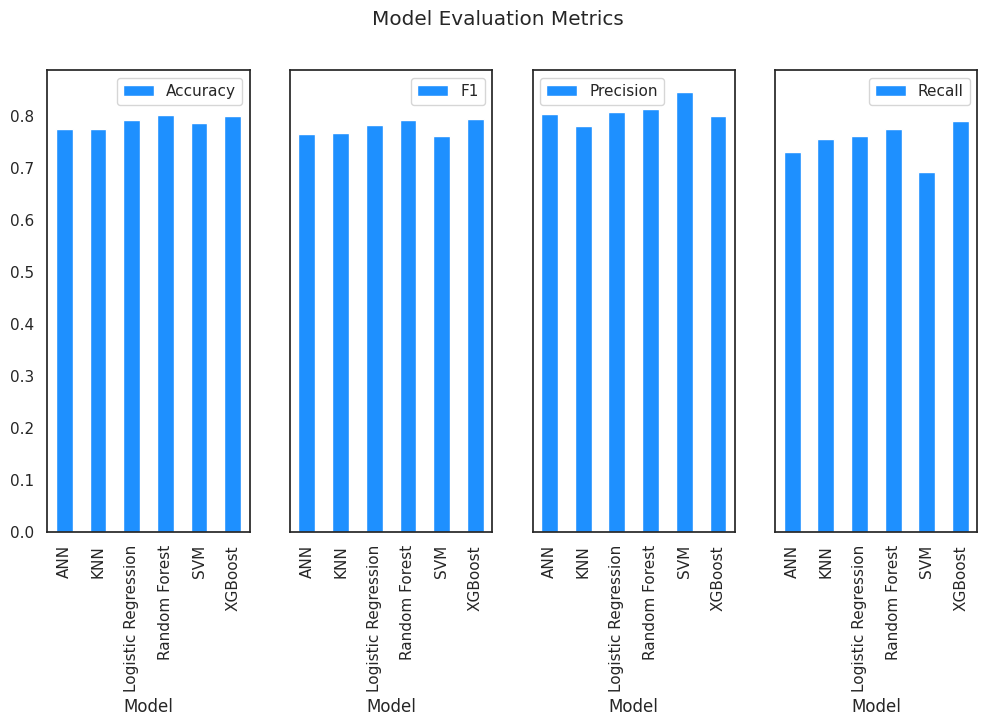

In [61]:
sns.set(style='white', font_scale=1)
fig, ax = plt.subplots(nrows=1, ncols=4, sharey=True, figsize = (12,6)) # Create a figure of subplots
for ax, column in zip(ax, df_summary.columns): # Loop through the columns
    df_summary.plot(kind='bar', y=column, ax=ax, color = 'dodgerblue')  # bar plot
fig.suptitle('Model Evaluation Metrics') # Set the title
plt.show()

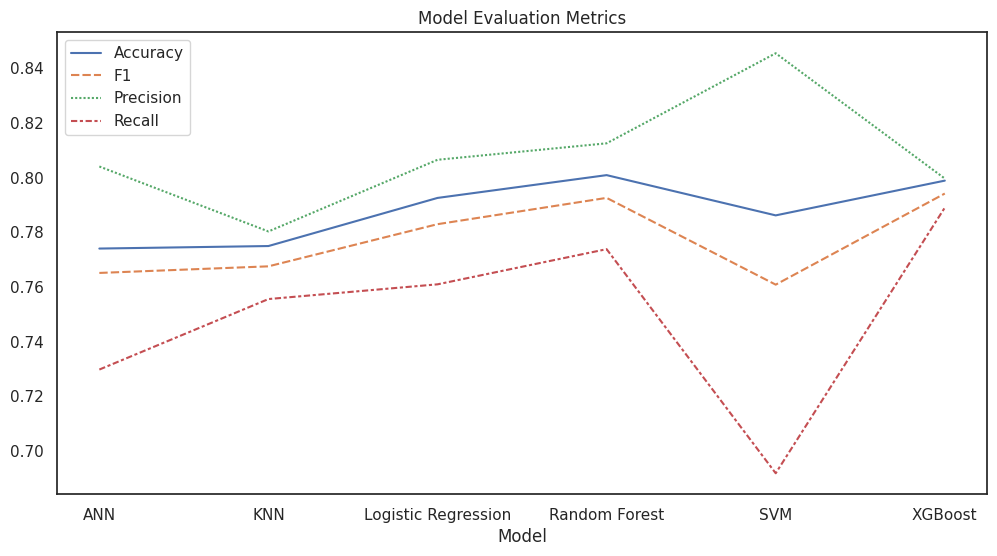

In [62]:
sns.set_style('white')
plt.subplots(figsize=(12,6))
sns.lineplot(data=df_summary)
plt.title('Model Evaluation Metrics')
plt.show()

## 8. Conclusion

#### The following conclusions can be made based on the study of the models:

*Overall Performance*: The most accurate models, Logistic Regression and Random Forest, predicted the target variable with accuracy rates of 79.25% and 80.09%, respectively. With accuracy rates of 77.40% and 77.49%, respectively, ANN and KNN likewise displayed comparable performance. Respectable accuracy results with SVM and XGBoost were 78.61% and 79.89%, respectively.

*Precision and Recall*: The maximum precision (80.65%) was reached using logistic regression, demonstrating this method's capacity to precisely identify positive instances. The highest recall was achieved by Random Forest (77.38%), indicating that it is most effective at catching events that are more likely to be positive.

*F1 Score*: XGBoost came in second with a score of 79.41%, closely after Random Forest with a score of 79.25%. These models show a well-balanced precision/recall trade-off.

## 9. Future Steps

#### The following actions can be made to better increase the models' prediction abilities:

*Feature Engineering*: Explore additional features or transformations to potentially improve the models' performance. Utilize feature selection techniques to identify the most relevant features for better predictive accuracy.

*Cross-Validation*: Use cross-validation to evaluate the robustness of the models and lessen overfitting problems. Fold the dataset numerous times and compare the models using various sets for training and validation.

*External Data*: To improve the predictive abilities of the models, take into account including extra pertinent data sources, if accessible.

THE END:D